In [2]:
import numpy as np
import pandas as pd

transactions = []

with open("groceries.csv", "r") as f:
    transactions = [[*filter(bool, row.strip().split(','))] for row in f.readlines()]


In [20]:
# check how many unique items there are
unique_items = np.unique([x for y in transactions for x in y])
print(unique_items.shape)
print(unique_items)

(169,)
['Instant food products' 'UHT-milk' 'abrasive cleaner' 'artif. sweetener'
 'baby cosmetics' 'baby food' 'bags' 'baking powder' 'bathroom cleaner'
 'beef' 'berries' 'beverages' 'bottled beer' 'bottled water' 'brandy'
 'brown bread' 'butter' 'butter milk' 'cake bar' 'candles' 'candy'
 'canned beer' 'canned fish' 'canned fruit' 'canned vegetables' 'cat food'
 'cereals' 'chewing gum' 'chicken' 'chocolate' 'chocolate marshmallow'
 'citrus fruit' 'cleaner' 'cling film/bags' 'cocoa drinks' 'coffee'
 'condensed milk' 'cooking chocolate' 'cookware' 'cream' 'cream cheese '
 'curd' 'curd cheese' 'decalcifier' 'dental care' 'dessert' 'detergent'
 'dish cleaner' 'dishes' 'dog food' 'domestic eggs'
 'female sanitary products' 'finished products' 'fish' 'flour'
 'flower (seeds)' 'flower soil/fertilizer' 'frankfurter' 'frozen chicken'
 'frozen dessert' 'frozen fish' 'frozen fruits' 'frozen meals'
 'frozen potato products' 'frozen vegetables' 'fruit/vegetable juice'
 'grapes' 'hair spray' 'ham' 

In [4]:
# check if there are any duplicates
np.sum([len([*filter(lambda y: x.count(y) != 1, x)]) for x in transactions])

0

In [5]:
# mask to array indexes
index_map = {x: i for i, x in enumerate(unique_items)}
index_map_reverse = {i: x for i, x in enumerate(unique_items)}
def vector_from_entry(transaction):
    result = np.zeros(unique_items.size)
    for item in transaction:
        result[index_map[item]] = 1
    return result

transactions_binary = [vector_from_entry(x) for x in transactions]

10

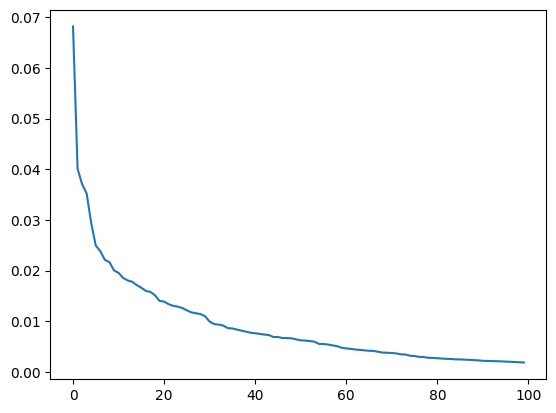

In [6]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


model = PCA(n_components=100).fit(transactions_binary)

plt.plot(model.explained_variance_ratio_)
n_components = model.explained_variance_ratio_[model.explained_variance_ratio_ > 0.02].size
n_components

In [7]:
from sklearn.manifold import TSNE
pca_model = PCA(n_components=n_components, random_state=42)
pca_result = pca_model.fit_transform(transactions_binary)
tsne_model = TSNE(random_state=42)
tsne = tsne_model.fit_transform(pca_result)

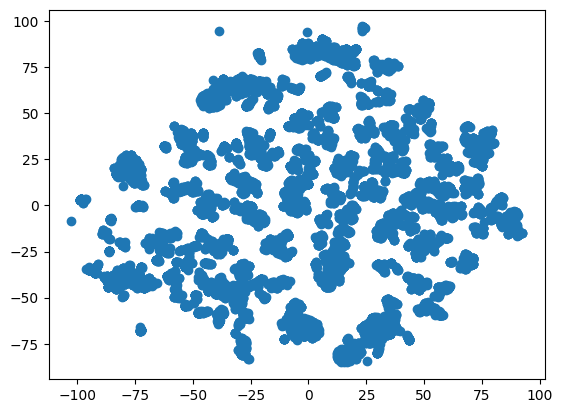

In [8]:
plt.scatter(tsne.T[0], tsne.T[1])

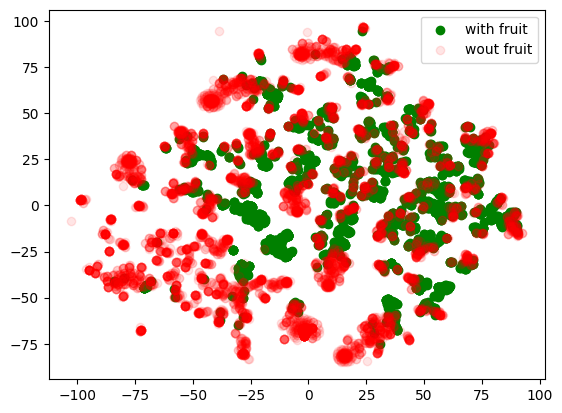

In [9]:
transactions_with_fruit = [any("fruit" in y for y in x) for x in transactions]

vis = tsne

g1 = vis[transactions_with_fruit].T
g2 = vis[np.logical_not(transactions_with_fruit)].T

fig, axe = plt.subplots()

axe.scatter(g1[0], g1[1], c="green", label="with fruit")
axe.scatter(g2[0], g2[1], c="red", alpha=0.1, label="wout fruit")
axe.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


24


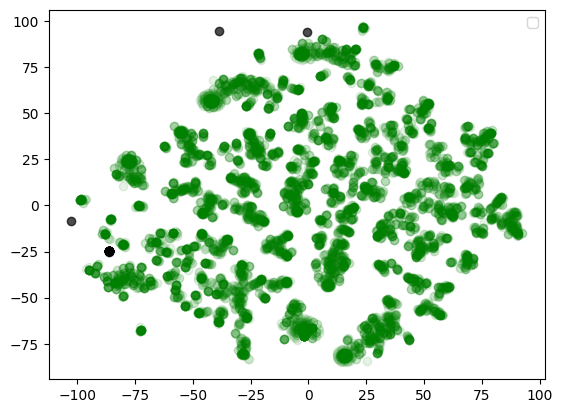

In [10]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(min_samples=20, eps=6).fit_predict(tsne)
print(np.unique(dbscan).size)

unclassified = tsne[dbscan == -1].T
classified = tsne[dbscan != -1].T


fig, axe = plt.subplots()

axe.scatter(unclassified[0], unclassified[1], c="black", alpha=0.7)
axe.scatter(classified[0], classified[1], c="green", alpha=0.1)
plt.legend()



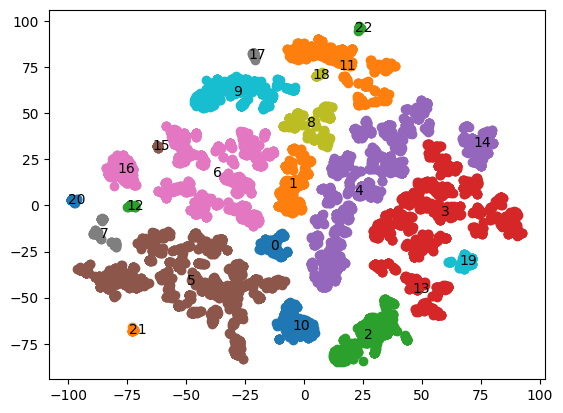

In [11]:

fig, axe = plt.subplots()

for group_number in np.unique(dbscan[dbscan != -1]):
    c = tsne[dbscan == group_number].T
    groupAvgX = np.mean(c[0]) - 2
    groupAvgY = np.mean(c[1]) - 2
    axe.text(groupAvgX, groupAvgY, group_number)
    axe.scatter(c[0], c[1], label=f"group {group_number}")
# voronoi?

In [12]:
from collections import Counter
results = {}
transactions_array = np.matrix(transactions_binary)
groups = np.unique(dbscan[dbscan != -1])
print(groups.size)
for group in groups:
    t = transactions_array[dbscan == group]
    
    iterated = t.nonzero()
    c = Counter([index_map_reverse[j] for i, j in zip(*iterated)])
    results[str(group)] = c.most_common(5)


for i, x in results.items():
    print(i, x)


23
0 [('citrus fruit', 95), ('pip fruit', 89), ('coffee', 17), ('margarine', 16), ('butter', 16)]
1 [('yogurt', 395), ('tropical fruit', 50), ('citrus fruit', 47), ('bottled water', 45), ('root vegetables', 41)]
2 [('whole milk', 535), ('newspapers', 49), ('whipped/sour cream', 41), ('brown bread', 35), ('butter', 32)]
3 [('whole milk', 1267), ('other vegetables', 736), ('yogurt', 551), ('soda', 394), ('root vegetables', 322)]
4 [('other vegetables', 1167), ('rolls/buns', 569), ('soda', 420), ('yogurt', 338), ('root vegetables', 256)]
5 [('newspapers', 128), ('coffee', 104), ('whipped/sour cream', 85), ('chocolate', 82), ('fruit/vegetable juice', 81)]
6 [('shopping bags', 325), ('bottled water', 299), ('pastry', 239), ('tropical fruit', 218), ('sausage', 208)]
7 [('specialty bar', 34), ('specialty chocolate', 34), ('beverages', 32), ('chewing gum', 5), ('photo/film', 3)]
8 [('soda', 292), ('bottled water', 139), ('shopping bags', 106), ('yogurt', 88), ('fruit/vegetable juice', 44)]
9 [

NameError: name 'y_true' is not defined

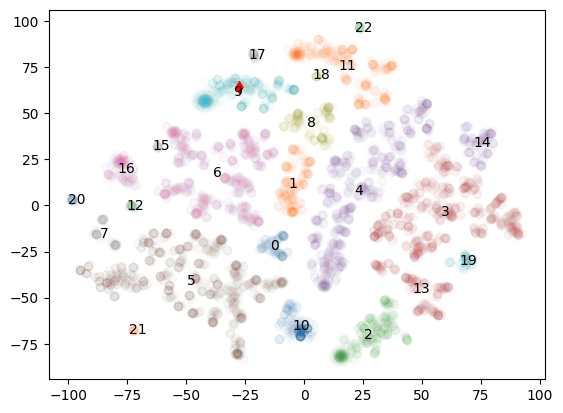

In [37]:
myRecord = ['soda', 'margarine']
myVector = vector_from_entry(myRecord)
a = pca_model.transform([myVector])
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(10).fit(pca_result, dbscan)
group = knn_model.predict(a)


# ten regresor zadziałał lepiej
from sklearn.neighbors import KNeighborsRegressor

# Choose a nearest neighbors regression model
regressor = KNeighborsRegressor(n_neighbors=10)  # You can adjust the number of neighbors

# Train the regressor
regressor.fit(pca_result, tsne)

# Assuming X_new_point is the new point you want to fit into the t-SNE layout
X_new_point_transformed = regressor.predict(a)
X_new_point_transformed


fig, axe = plt.subplots()

for group_number in np.unique(dbscan[dbscan != -1]):
    c = tsne[dbscan == group_number].T
    groupAvgX = np.mean(c[0]) - 2
    groupAvgY = np.mean(c[1]) - 2
    axe.text(groupAvgX, groupAvgY, group_number)
    axe.scatter(c[0], c[1], label=f"group {group_number}", alpha=0.01)
axe.scatter(X_new_point_transformed.T[0], X_new_point_transformed.T[1], c="red", marker="d")


def rmse(y_true, y_pred):
# Calculate squared differences
    squared_diff = (y_true - y_pred) ** 2
    
    # Calculate mean squared difference
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse_value = np.sqrt(mean_squared_diff)
    
    return rmse_value


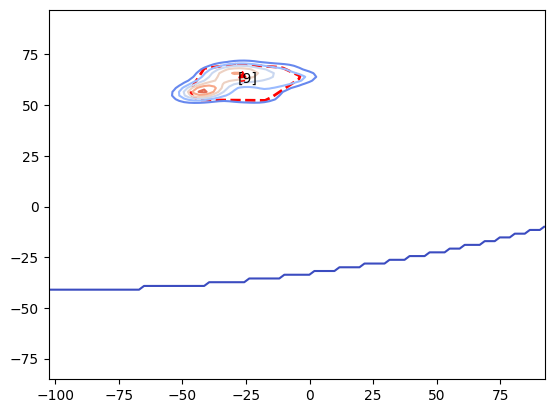

In [14]:
# Kernel Density Estimation (KDE) is a non-parametric method for estimating the probability density 
# function (PDF) of a continuous random variable. It is commonly used for visualizing the 
# underlying distribution of data points in a high-dimensional space.

from scipy.stats import gaussian_kde
from scipy.spatial import ConvexHull
# Estimate density using KDE

x, y = np.meshgrid(np.linspace(min(tsne[:, 0]), max(tsne[:, 0]), 100),
                   np.linspace(min(tsne[:, 1]), max(tsne[:, 1]), 100))

fig, axe = plt.subplots()

t = tsne[dbscan == group]
kde = gaussian_kde(t.T, bw_method=0.5)
groupAvgX = np.mean(t.T[0])
groupAvgY = np.mean(t.T[1])
axe.text(groupAvgX, groupAvgY, group)
z = kde(np.vstack([x.flatten(), y.flatten()]))
hull = ConvexHull(t)
axe.plot(np.append(t[hull.vertices, 0], t[hull.vertices[0], 0]),
            np.append(t[hull.vertices, 1], t[hull.vertices[0], 1]), 'r--', lw=2)
# Set contour levels
# Set contour levels
levels = np.linspace(0.1, 1.0, 100)
axe.contour(x, y, z.reshape(x.shape), cmap='coolwarm')

axe.scatter(X_new_point_transformed.T[0], X_new_point_transformed.T[1], c="red", marker="d")

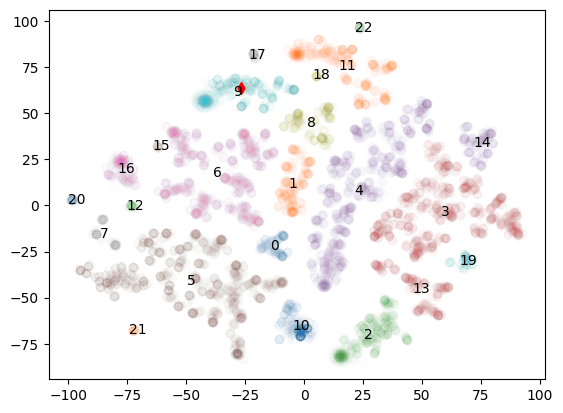

In [15]:

fig, axe = plt.subplots()

for group_number in np.unique(dbscan[dbscan != -1]):
    c = tsne[dbscan == group_number].T
    groupAvgX = np.mean(c[0]) - 2
    groupAvgY = np.mean(c[1]) - 2
    axe.text(groupAvgX, groupAvgY, group_number)
    axe.scatter(c[0], c[1], label=f"group {group_number}", alpha=0.01)


axe.scatter(X_new_point_transformed.T[0], X_new_point_transformed.T[1], c="red", marker="d")

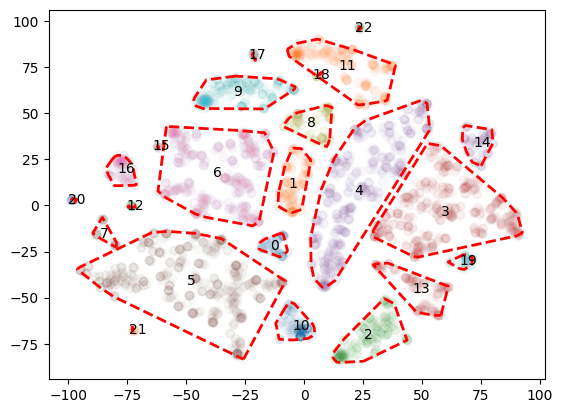

<Figure size 800x600 with 0 Axes>

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
fig, axe = plt.subplots()
# Plot the data points
plt.figure(figsize=(8, 6))

for group_number in np.unique(dbscan[dbscan != -1]):
    c = tsne[dbscan == group_number].T
    groupAvgX = np.mean(c[0]) - 2
    groupAvgY = np.mean(c[1]) - 2
    axe.text(groupAvgX, groupAvgY, group_number)
    axe.scatter(c[0], c[1], label=f"group {group_number}", alpha=0.01)

# Plot the convex hulls of clusters
for cluster_label in groups:
    cluster_points = tsne[dbscan == cluster_label]
    hull = ConvexHull(cluster_points)
    axe.plot(np.append(cluster_points[hull.vertices, 0], cluster_points[hull.vertices[0], 0]),
             np.append(cluster_points[hull.vertices, 1], cluster_points[hull.vertices[0], 1]), 'r--', lw=2)
plt.show()

In [31]:
csv = ""
for x in unique_items:
    csv += f"{x}\n"
with open("unique_items.txt", "w") as f:
    f.write(csv)

In [34]:
import json
generated_labels = ''
with open("gpt_labels.json", "r") as file:
    generated_labels = json.load(file)
print(generated_labels)

[{'label': 'Convenient Breakfast', 'items': ['Instant food products', 'UHT-milk', 'butter', 'rolls/buns']}, {'label': 'Healthy Snack Pack', 'items': ['Berries', 'nuts/prunes', 'yogurt']}, {'label': 'Household Essentials', 'items': ['Detergent', 'kitchen towels', 'toilet cleaner']}, {'label': 'Weekend Treats', 'items': ['Bottled beer', 'chocolate', 'potato products']}, {'label': 'Baking Delights', 'items': ['Baking powder', 'flour', 'chocolate marshmallow', 'cake bar']}, {'label': 'Picnic Favorites', 'items': ['Bottled water', 'canned fish', 'crackers', 'fruits/vegetable juice']}, {'label': 'Dinner Essentials', 'items': ['Beef', 'onions', 'pasta', 'sauces']}, {'label': 'Refreshing Beverages', 'items': ['Beverages', 'fruit/vegetable juice', 'soda', 'wine']}, {'label': 'Pamper Yourself', 'items': ['Bath products', 'skin care', 'candles']}, {'label': 'Pet Care Bundle', 'items': ['Cat food', 'dog food', 'pet care products']}, {'label': 'Outdoor Adventure Pack', 'items': ['Canned beer', 'sau

In [43]:
from transformers import pipeline

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Define example text and candidate labels
text = "Relax. Beauty. Cheese."
labels = ["Convenient Breakfast", "Healthy Snack Pack", "Household Essentials", "Weekend Treats", "Baking Delights",
    "Picnic Favorites", "Dinner Essentials", "Refreshing Beverages", "Pamper Yourself", "Pet Care Bundle",
    "Outdoor Adventure Pack", "Breakfast Boost", "Home Spa Day", "Family Movie Night", "Office Snack Supply",
    "Weekend BBQ Essentials", "Morning Energy Boost", "Cooking Enthusiast Kit", "Healthy Lunch Pack",
    "Italian Cuisine Night", "Party Appetizers", "Cozy Night In", "International Flavors", "Brunch Bonanza",
    "Afternoon Tea Selection", "Fitness Fuel", "Summer Picnic Basket", "Healthy Start Pack", "Game Night Snacks",
    "Quick Dinner Fix"]

# Perform zero-shot classification
classification = classifier(text, labels)

# Print classification results
print("Predicted label:", classification['labels'])
print("Score:", classification['scores'])

# So user submits the prompt and zero point classifier classifies them to a group of purchases.

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Predicted label: ['Pamper Yourself', 'Cozy Night In', 'Home Spa Day', 'Refreshing Beverages', 'Healthy Snack Pack', 'Picnic Favorites', 'Italian Cuisine Night', 'Weekend Treats', 'Healthy Start Pack', 'Morning Energy Boost', 'International Flavors', 'Afternoon Tea Selection', 'Healthy Lunch Pack', 'Outdoor Adventure Pack', 'Pet Care Bundle', 'Family Movie Night', 'Summer Picnic Basket', 'Quick Dinner Fix', 'Game Night Snacks', 'Baking Delights', 'Weekend BBQ Essentials', 'Cooking Enthusiast Kit', 'Household Essentials', 'Breakfast Boost', 'Convenient Breakfast', 'Office Snack Supply', 'Party Appetizers', 'Brunch Bonanza', 'Dinner Essentials', 'Fitness Fuel']
Score: [0.2818012833595276, 0.07548403739929199, 0.0729210302233696, 0.0535845085978508, 0.037069011479616165, 0.036561328917741776, 0.029931968078017235, 0.028696108609437943, 0.026302164420485497, 0.02497938461601734, 0.024908334016799927, 0.02365344576537609, 0.023518206551671028, 0.022085338830947876, 0.021301260218024254, 0.02

In [45]:
# So, the user has to input the prompt and get classified to one of the groups.

# The groups should be generated automatically once classification is invalidated.

# Classification should be cached by parameters.

# 1: User enters a prompt,
# Show assignment to a group or few groups on the TSNE graph,
# Show recommended items and groups

# Graph should be pannable, with interactive legend.
# Graph should show current placement with opaque database tsne in the bg like currently
# Once label is clicked, the graph zooms in and shows each purchase in group
# each item splits the scatterplot dot in n, max n is 3 then other? (based on most popular in group?)

# User may also activate direct mode, where mouseover graph shows probabilities of each purchase, group assignment etc on given pixel
# User may also enter the list of purchases from an iterable list with ai generated images to check assignment based on purchased goods
# This can be integrated with what is in [mark 1], Prompt based selection row, selected items row.

# first and for most I need prompt based item recommendation, [both classified classes and single items]

unique_items.size

169

In [46]:
from transformers import pipeline

# Load zero-shot classification pipeline
classifier = pipeline("zero-shot-classification")

# Define example text and candidate labels
text = "Relax. Beauty. Cheese."
labels = [*unique_items]

# Perform zero-shot classification
classification = classifier(text, labels)

# Print classification results
print("Predicted label:", classification['labels'])
print("Score:", classification['scores'])

# So user submits the prompt and zero point classifier classifies them to a group of purchases.

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


Predicted label: ['softener', 'artif. sweetener', 'spread cheese', 'decalcifier', 'tidbits', 'sliced cheese', 'curd', 'soft cheese', 'salty snack', 'specialty cheese', 'zwieback', 'cleaner', 'cream', 'roll products ', 'preservation products', 'whipped/sour cream', 'specialty fat', 'hygiene articles', 'sound storage medium', 'UHT-milk', 'snack products', 'curd cheese', 'red/blush wine', 'specialty bar', 'misc. beverages', 'sweet spreads', 'Instant food products', 'finished products', 'cream cheese ', 'specialty vegetables', 'baby food', 'candy', 'skin care', 'dessert', 'male cosmetics', 'make up remover', 'white wine', 'frozen dessert', 'sauces', 'packaged fruit/vegetables', 'sugar', 'pickled vegetables', 'cereals', 'processed cheese', 'nut snack', 'salt', 'dishes', 'bags', 'photo/film', 'pip fruit', 'rolls/buns', 'condensed milk', 'baby cosmetics', 'ice cream', 'popcorn', 'beverages', 'pasta', 'sparkling wine', 'oil', 'cling film/bags', 'yogurt', 'ready soups', 'other vegetables', 'sem